<a href="https://colab.research.google.com/github/mgnarag/Geology-image-classification/blob/main/Model_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Installing packages and connecting the google drive**

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

In [35]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/Geology (Ate Grass)/3 classes/"

# **2.Preparing the training and validation dataset**
### make sure to change the `img_size` to the correct image size of the model:
*   For ALEXNET, it is 227 by 227
*   For VGG16, it is 224 by 224
*   For RESNET, it is 224 by 224




In [ ]:
img_size = 227

# Function to resize images to img_size
def resize_image(image_path):
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    return img_array


def rot_and_flip(img):
  x = np.rot90(img, k=-1) #90
  train_images.append(x)
  train_labels.append(class_name)
  train_images.append(np.fliplr(x))
  train_labels.append(class_name)
  return x

# Load and preprocess training data
train_images = []
train_labels = []

train_dir = file_path + '/Training/'
classes = os.listdir(train_dir)

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        x = resize_image(image_path)
        train_images.append(x)
        train_labels.append(class_name)
        train_images.append(np.fliplr(x))
        train_labels.append(class_name)
        #rotate and flip
        x = rot_and_flip(x) #90
        x = rot_and_flip(x) #180
        x = rot_and_flip(x) #270


# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print('shape of total dataset', np.shape(train_images))
print('shape of total dataset label', np.shape(train_labels))

# Encode class names into numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert numerical labels to one-hot encoded vectors
train_labels = to_categorical(train_labels_encoded, num_classes=3)

# Split the dataset into training and validation sets
#train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

print("splitting to 80-20 training-validation")
print('shape of dataset for training', np.shape(train_images))
print('shape of dataset label for training', np.shape(train_labels))
print('shape of dataset for validation', np.shape(val_images))
print('shape of dataset label for validation', np.shape(val_labels))

## Visualize:

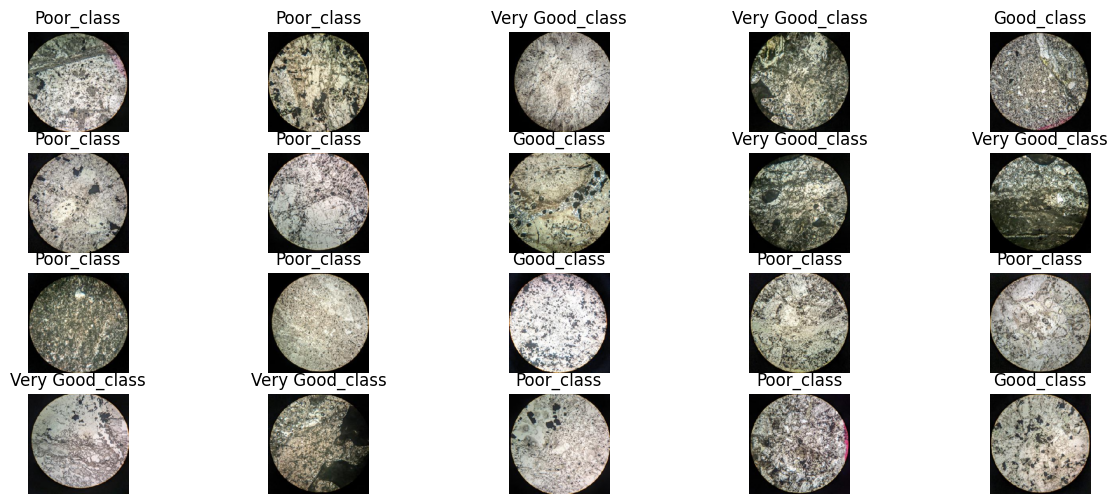

In [27]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(images, labels, class_names, num_images=20):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(4, 5, i+1)
        plt.imshow(images[i])
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

# Decode one-hot encoded labels back to class names
class_names = label_encoder.classes_

# Display the first 20 training images
display_images(train_images[:20], train_labels[:20], class_names)


# **Training the model**

We will train three (3) different models. We will run them separately.


## **RUN THIS FOR ALEXNET**
There is no built-in model for alexnet so we have to create it from scratch

In [33]:
#AlexNet architecture from scratch
alex_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, kernel_size=(3,3), activation='relu'),
    Conv2D(384, kernel_size=(3,3), activation='relu'),
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    #Dropout(0.5),
    Dense(4096, activation='relu'),
    #Dropout(0.5),
    Dense(3, activation='softmax')
])


from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

alex_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Train  model
alex_model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))
alex_model.save(file_path + "Models/alex_model")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## **RUN THIS FOR VGG16**
There is already a built-in model for vgg16 so we don't need to create it from scratch

In [ ]:
# Load VGG16 mode:
vgg_base = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
#Add "weights='imagenet'" if we want pretrained weights


# Freeze the pre-trained layers
for layer in vgg_base.layers:
    layer.trainable = True

# Add custom classifier layers on top of the pre-trained layers
x = Flatten()(vgg_base.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output = Dense(3, activation='softmax')(x) #because we have 3 classes

# Create the full model
vgg_model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
vgg_model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))
vgg_model.save(file_path + "Models/vgg_model.h5")

## **RUN THIS FOR RESNET**

In [ ]:
resnet_base = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in resnet_base.layers:
    layer.trainable = True

# Add custom classifier layers on top of the pre-trained layers
x = Flatten()(resnet_base.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the full model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
resnet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
resnet_model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))
resnet_model.save(file_path + "Models/resnet_model.h5")

## **TEST THE MODEL**

#### Load testing dataset:

In [29]:
# Load and preprocess test data
test_images = []
test_labels = []

test_dir = file_path + '/Testing/'

for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        test_images.append(resize_image(image_path))
        test_labels.append(class_name)

test_images = np.array(test_images)
# Encode class names into numerical labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Convert numerical labels to one-hot encoded vectors
test_labels = to_categorical(test_labels_encoded, num_classes=3)  # Assuming 3 output classes

print('shape of test data',np.shape(test_labels))

shape of test data (250, 3)


#### Testing and calculating the evalution metrics
Don't forget to change the model on the first line:


In [30]:
model = alex_model #either alex_model, vgg_model, resnet_model
model_name = str("alexnet") #change to vgg, resnet
# Predict probabilities for test data
y_pred_prob = model.predict(test_images)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded test labels to class labels
y_true = np.argmax(test_labels, axis=1)

8/8 [==============================] - 0s 50ms/step


Overall Precision: 0.6062635056746533
Overall Recall: 0.556
Overall F1-Score: 0.5307628756785384
Classification Report:
                  precision    recall  f1-score   support

     Good_class       0.62      0.23      0.33       105
     Poor_class       0.66      0.80      0.73       123
Very Good_class       0.26      0.73      0.39        22

       accuracy                           0.56       250
      macro avg       0.51      0.59      0.48       250
   weighted avg       0.61      0.56      0.53       250



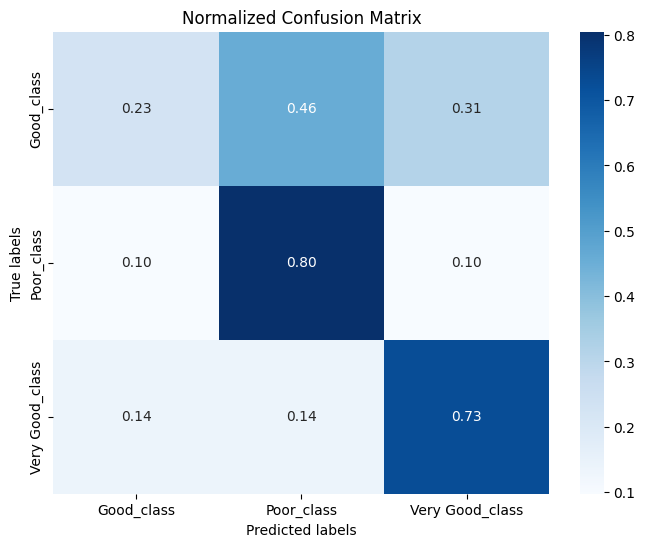

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')

# Save confusion matrix image
plt.savefig(file_path + 'CM_'+model_name+'.png')

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Print overall precision, recall, and F1-score
print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-Score:", f1_score)


from sklearn.metrics import precision_recall_fscore_support, classification_report

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Print classification report
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

# Specify the file path
file_path_1 = file_path+ "/Metric_"+model_name+".txt"

# Save classification report to a text file along with precision, recall, and F1-score
with open(file_path_1, 'w') as f:
    f.write("Precision: {:.4f}\n".format(precision))
    f.write("Recall: {:.4f}\n".format(recall))
    f.write("F1-score: {:.4f}\n\n".format(f1_score))
    f.write("Classification Report:\n")
    f.write(report)
